## Reference

https://stackoverflow.com/questions/40994583/how-to-implement-tensorflows-next-batch-for-own-data

In [15]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Cifar10 Data

(50000, 32, 32, 3)


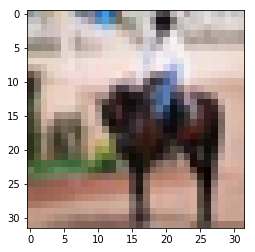

In [50]:
(X_train, y_train), (X_test, y_test) = tf.contrib.keras.datasets.cifar10.load_data()

print(X_train.shape)

plt.imshow(X_train[11])

## Make it Grey

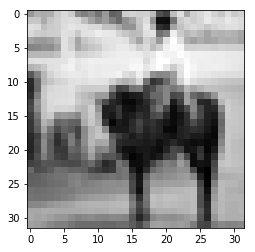

In [54]:
plt.imshow((X_train/255.0).mean(axis=3)[11], cmap='gray')

In [55]:
X_train = (X_train/255.0).mean(axis=3).reshape(-1, 32*32)
X_test = (X_test/255.0).mean(axis=3).reshape(-1, 32*32)

print(type(X_train))
print(X_train.shape)
print(y_train)
print(y_train.shape)

<class 'numpy.ndarray'>
(50000, 1024)
[[6]
 [9]
 [9]
 ..., 
 [9]
 [1]
 [1]]
(50000, 1)


### One-Hot Encoding

In [56]:
y_train = np.eye(10)[y_train.reshape(-1)]
y_test = np.eye(10)[y_test.reshape(-1)]

In [57]:
def conv_layer(input, size_in, size_out, name="conv"):
    with tf.name_scope(name):
        with tf.variable_scope("vs"):
            w = tf.get_variable(initializer=tf.truncated_normal([5, 5, size_in, size_out], stddev=0.1), name="{}_W".format(name))
            b = tf.get_variable(initializer=tf.constant(0.1, shape=[size_out]), name="{}_B".format(name))
            conv = tf.nn.conv2d(input, w, strides=[1, 1, 1, 1], padding="SAME")
            act = tf.nn.relu(conv + b)

            print(w.name)
            
            tf.summary.histogram("weights", w)
            tf.summary.histogram("biases", b)
            tf.summary.histogram("activations", act)

            return tf.nn.max_pool(act, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")

In [58]:
def fc_layer(input, size_in, size_out, name="fc"):
    with tf.name_scope(name):
        w = tf.Variable(tf.truncated_normal([size_in, size_out], stddev=0.1), name="W")
        b = tf.Variable(tf.constant(0.1, shape=[size_out]), name="B")
        act = tf.matmul(input, w) + b
        
        tf.summary.histogram("weights", w)
        tf.summary.histogram("biases", b)
        tf.summary.histogram("activations", act)

        return act

In [59]:
def dropout_layer(input, keep_prob, name="dropout"):
    with tf.name_scope(name):
        return tf.nn.dropout(input, keep_prob)        

In [60]:
def to_image_tensor(weights):
    ''' weights shape = (5, 5, 1, 32)
    '''
    weights = tf.reshape(weights, shape=(-1, 5, 5, 1))
    
    # scale weights to [0 255] and convert to uint8
    x_min = tf.reduce_min(weights)
    x_max = tf.reduce_max(weights)
    weights_0_to_1 = (weights - x_min) / (x_max - x_min)

    # Images that are represented using floating point values are expected to have values in the range [0,1). 
    # This op converts between data types, scaling the values appropriately before casting.
    weights_0_to_255_uint8 = tf.image.convert_image_dtype(weights_0_to_1, dtype=tf.uint8)
    
    return weights_0_to_255_uint8

In [61]:
def show_images(ndarr):
    ndarr = ndarr.squeeze()
    
    cols = 16
    rows = ndarr.shape[0] // cols

    print("cols = {}, rows = {}".format(cols, rows))
    fig, axes = plt.subplots(figsize=(30, 4), nrows=rows, ncols=cols, sharex=True, sharey=True)

    axes = np.hstack(axes)
    for sample, ax in zip(ndarr, axes):
        ax.imshow(sample, cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)    
    
    plt.show()

In [62]:
import numpy as np 

class Dataset:
    def __init__(self, X, y):
        self._index_in_epoch = 0
        self._epochs_completed = 0
        self._X = X
        self._y = y
        self._num_examples = X.shape[0]

    @property
    def X(self):
        return self._X

    @property
    def y(self):
        return self._y
    
    def next_batch(self, batch_size, shuffle=True):
        start = self._index_in_epoch
        
        if start == 0 and self._epochs_completed == 0:
            idx = np.arange(0, self._num_examples)  # get all possible indexes
            np.random.shuffle(idx)  # shuffle indexe
            self._X = self.X[idx]  # get list of `num` random samples
            self._y = self.y[idx]  # get list of `num` random samples

        # go to the next batch
        if start + batch_size > self._num_examples:
            self._epochs_completed += 1
            rest_num_examples = self._num_examples - start
            X_rest_part = self.X[start : self._num_examples]
            y_rest_part = self.y[start : self._num_examples]
            
            idx0 = np.arange(0, self._num_examples)  # get all possible indexes
            np.random.shuffle(idx0)  # shuffle indexes
            self._X = self.X[idx0]  # get list of `num` random samples
            self._y = self.y[idx0]  # get list of `num` random samples

            start = 0
            self._index_in_epoch = batch_size - rest_num_examples #avoid the case where the #sample != integar times of batch_size
            end =  self._index_in_epoch  
            X_new_part =  self._X[start:end]  
            y_new_part =  self._y[start:end]  
            
            return np.concatenate((X_rest_part, X_new_part), axis=0), np.concatenate((y_rest_part, y_new_part), axis=0)  
        else:
            self._index_in_epoch += batch_size
            end = self._index_in_epoch
            
            return self._X[start:end], self._y[start:end]

In [63]:
dataset = Dataset(np.arange(0, 5), np.arange(0, 5))
for i in range(3):
    X, y = dataset.next_batch(3)
    print(X)    
    print(y)        

[2 3 0]
[2 3 0]
[1 4 1]
[1 4 1]
[4 0 2]
[4 0 2]


vs/conv1_W:0
vs/conv2_W:0
step 0, training accuracy 0.1
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


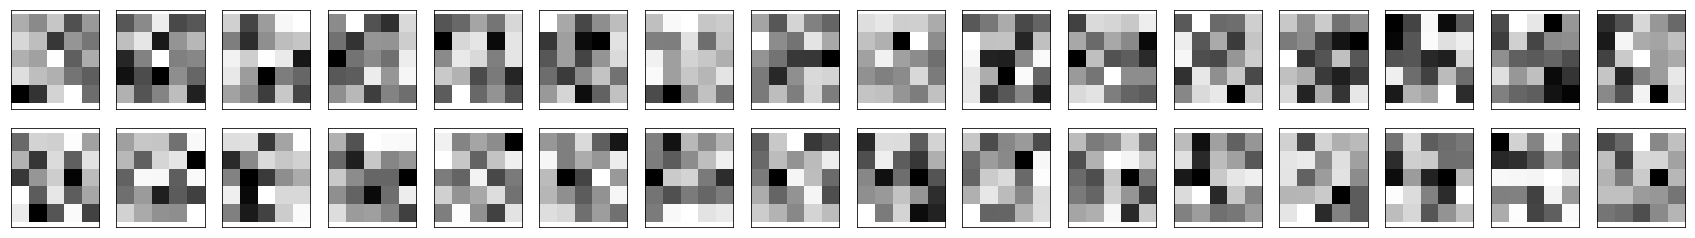

step 1000, training accuracy 0.3
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


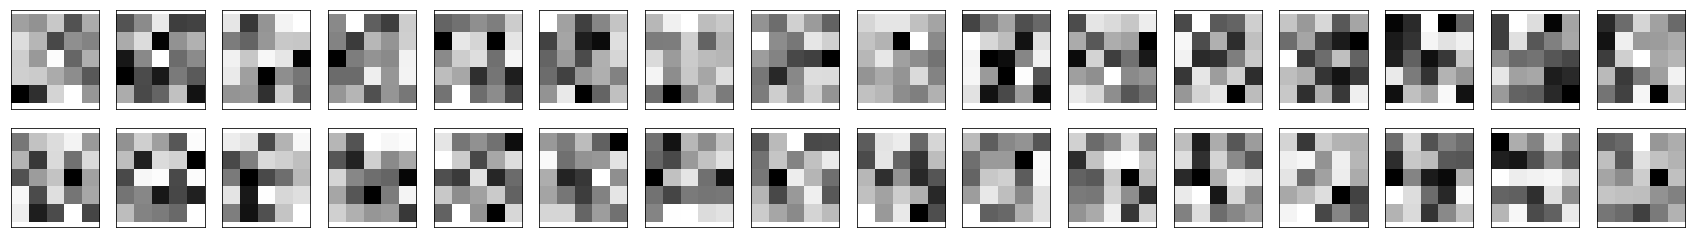

step 2000, training accuracy 0.43
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


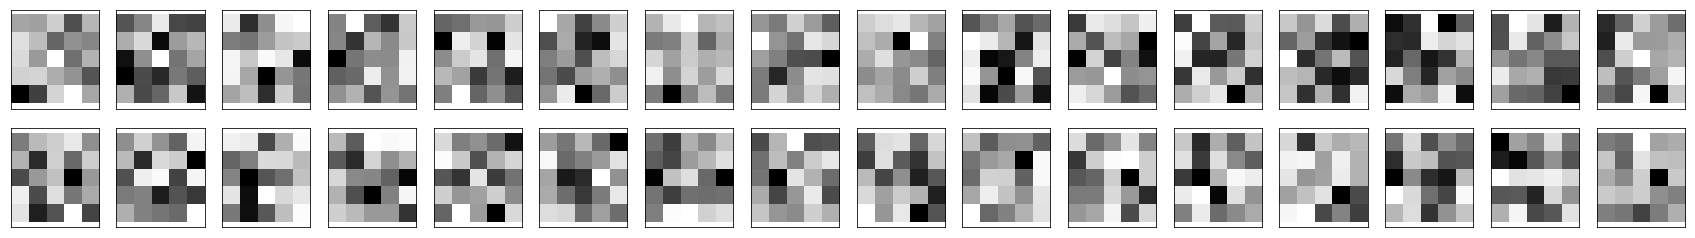

step 3000, training accuracy 0.42
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


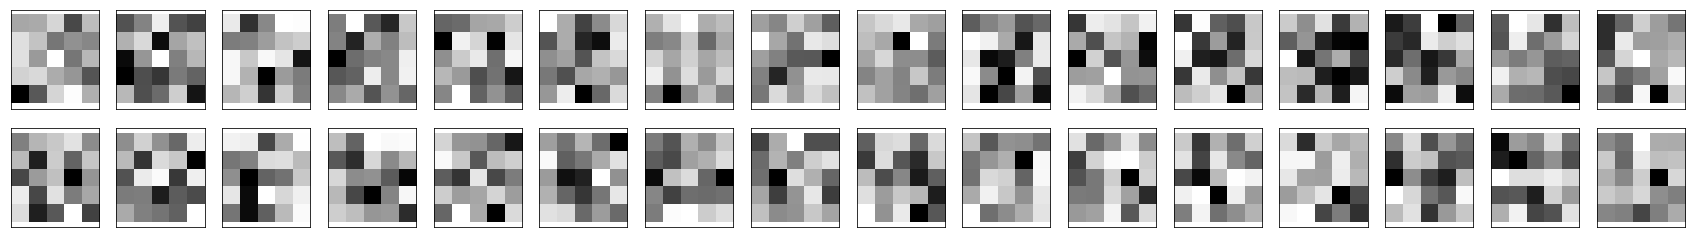

step 4000, training accuracy 0.46
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


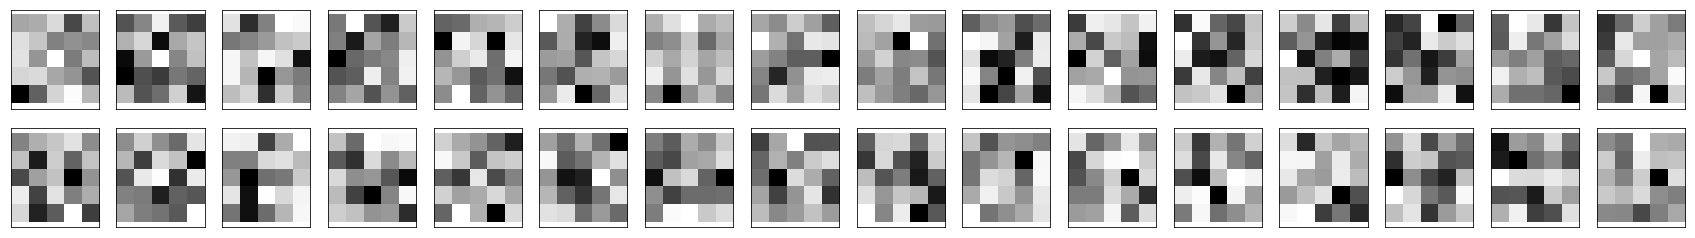

step 5000, training accuracy 0.45
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


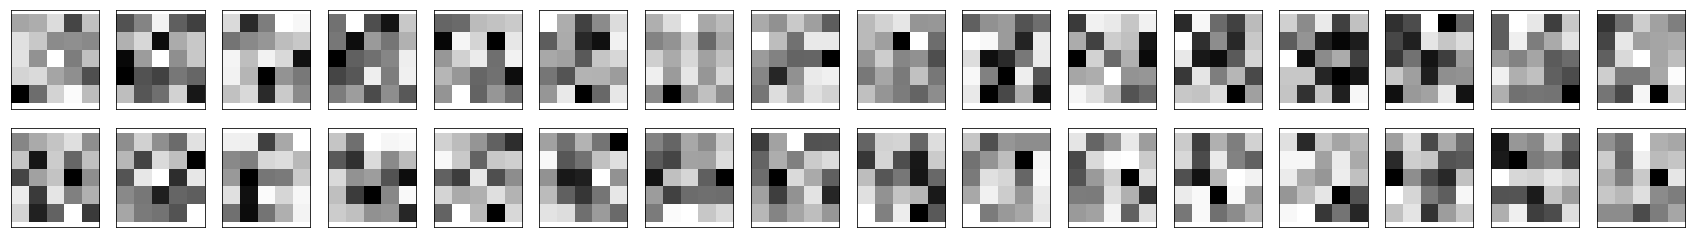

step 6000, training accuracy 0.5
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


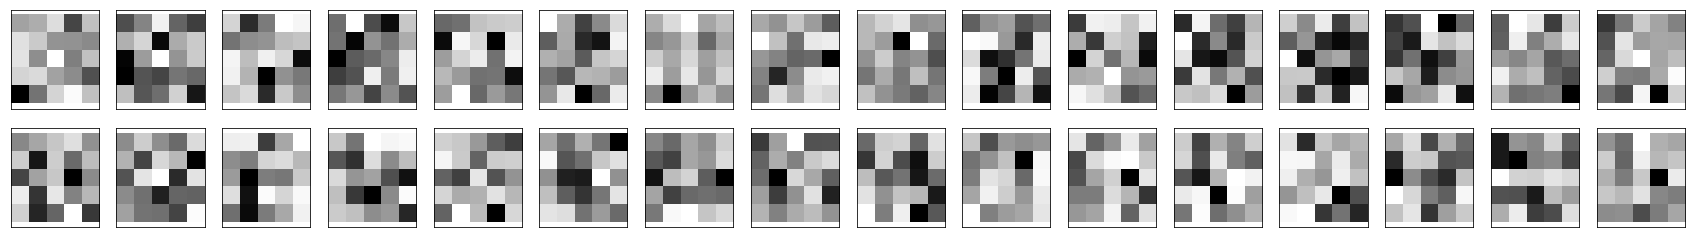

step 7000, training accuracy 0.65
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


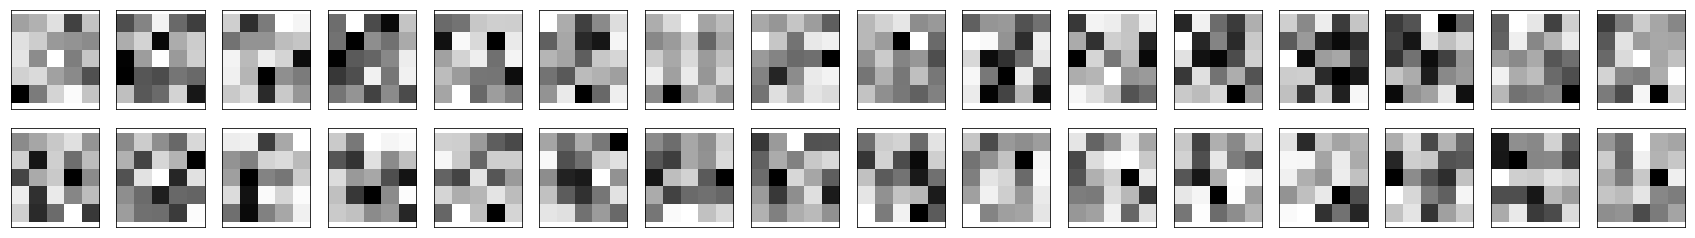

step 8000, training accuracy 0.55
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


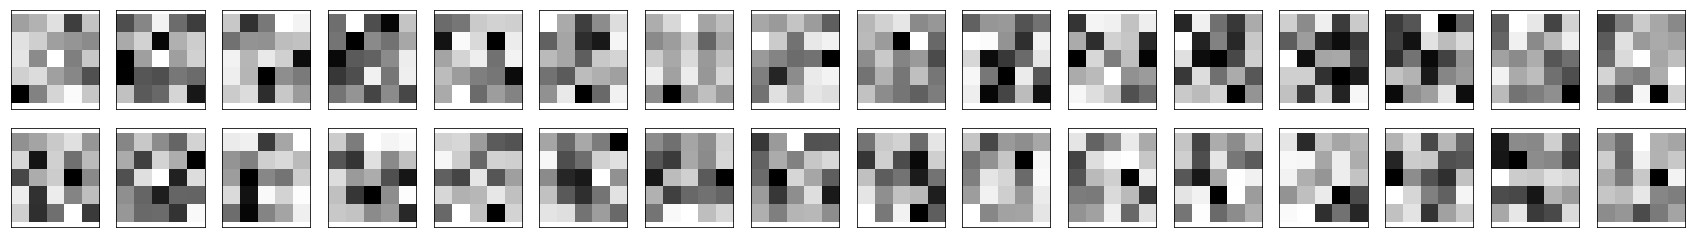

step 9000, training accuracy 0.5
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


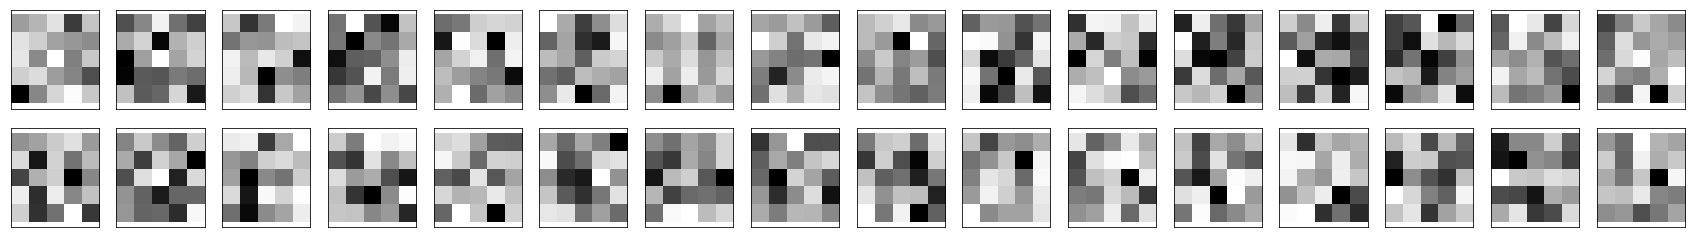

step 10000, training accuracy 0.62
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


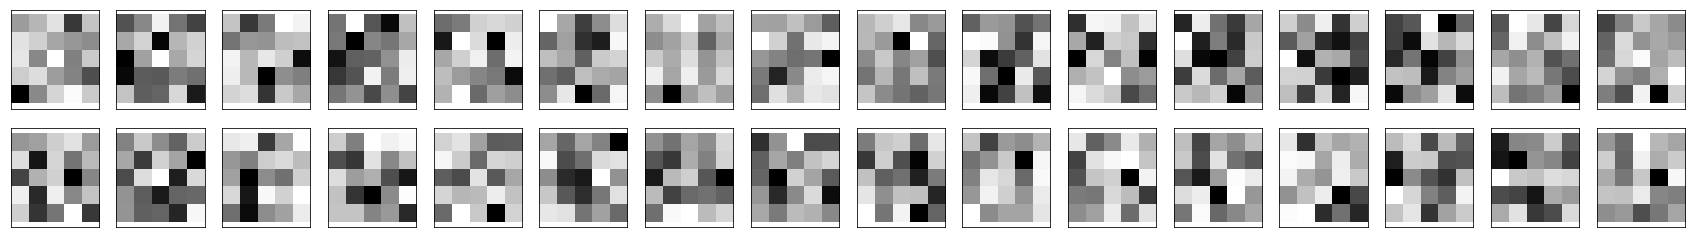

step 11000, training accuracy 0.62
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


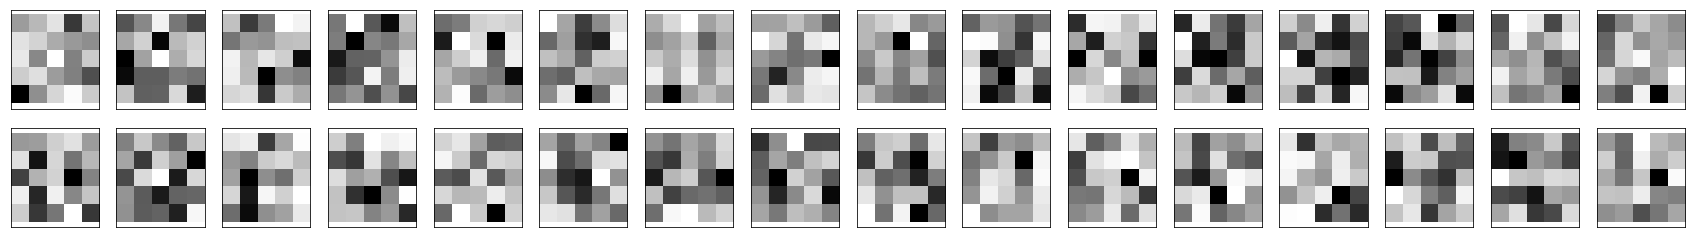

step 12000, training accuracy 0.66
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


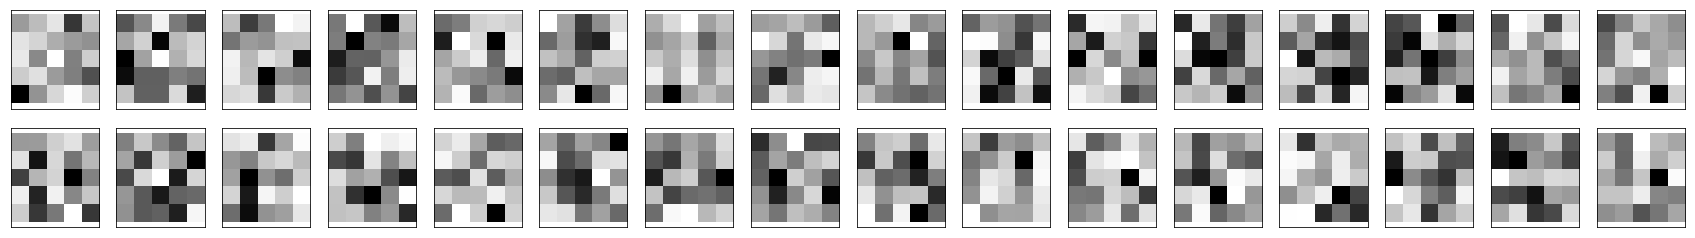

step 13000, training accuracy 0.66
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


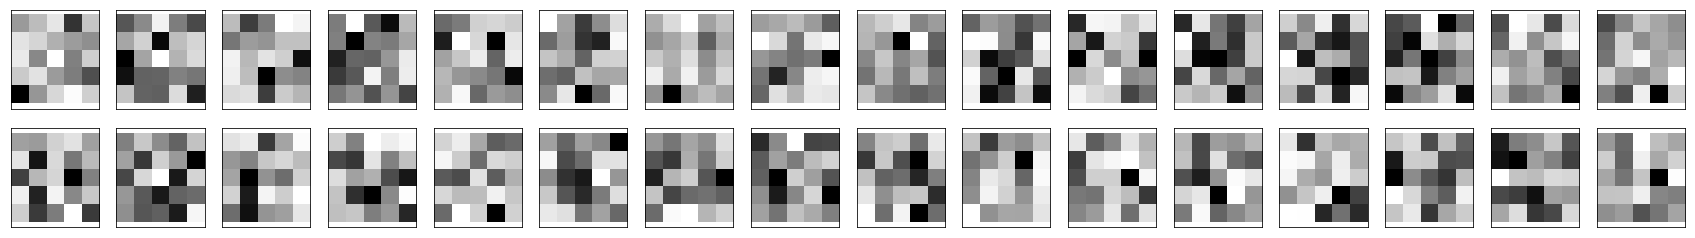

step 14000, training accuracy 0.65
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


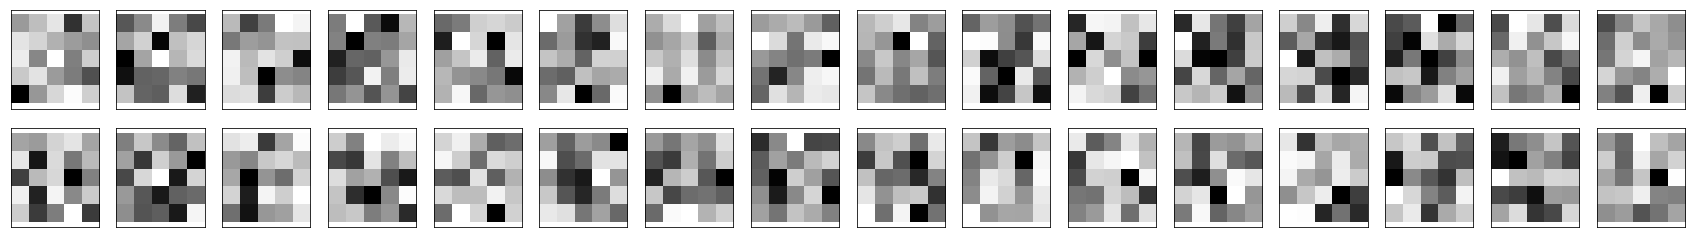

step 15000, training accuracy 0.63
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


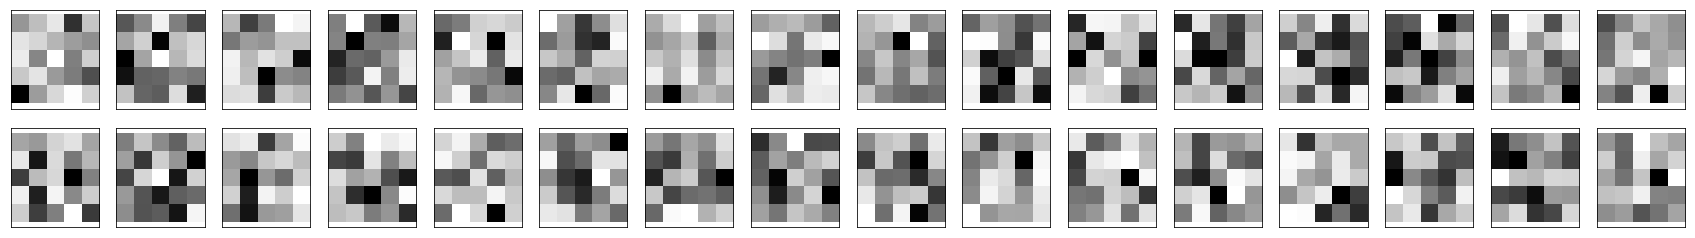

step 16000, training accuracy 0.68
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


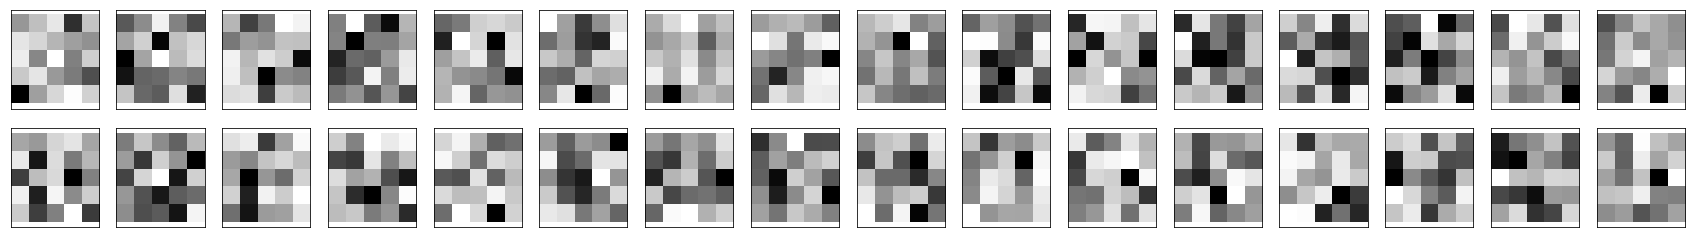

step 17000, training accuracy 0.61
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


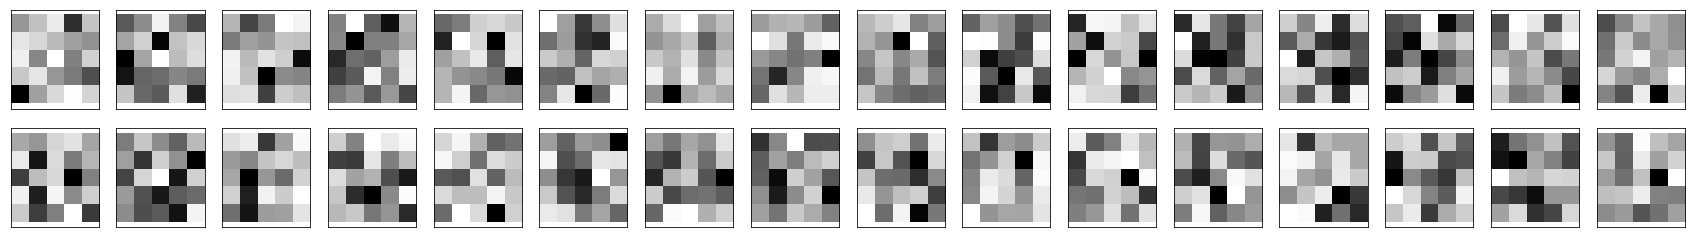

step 18000, training accuracy 0.65
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


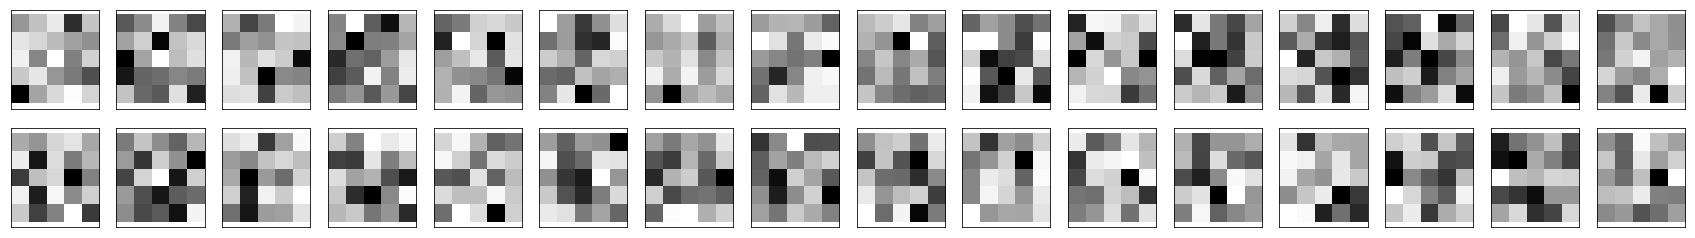

step 19000, training accuracy 0.68
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


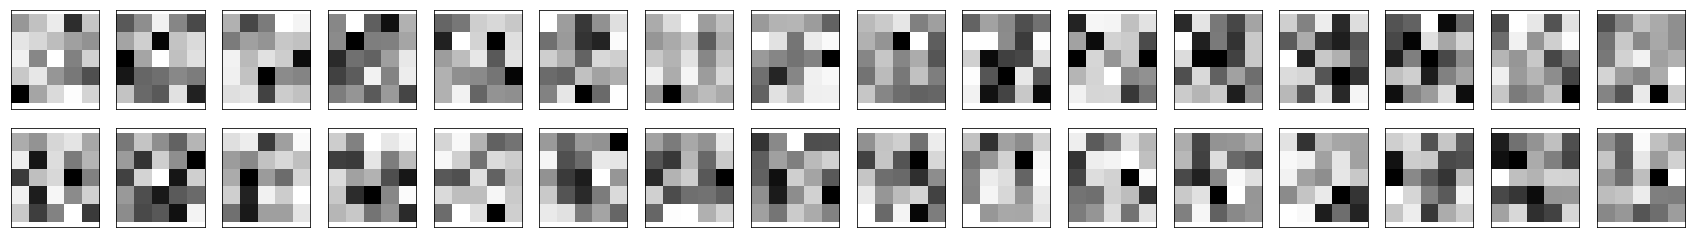

step 20000, training accuracy 0.71
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


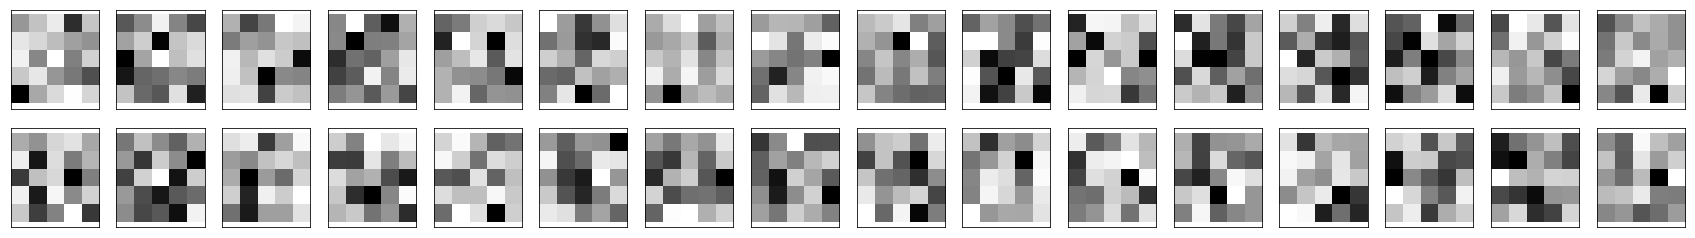

step 21000, training accuracy 0.62
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


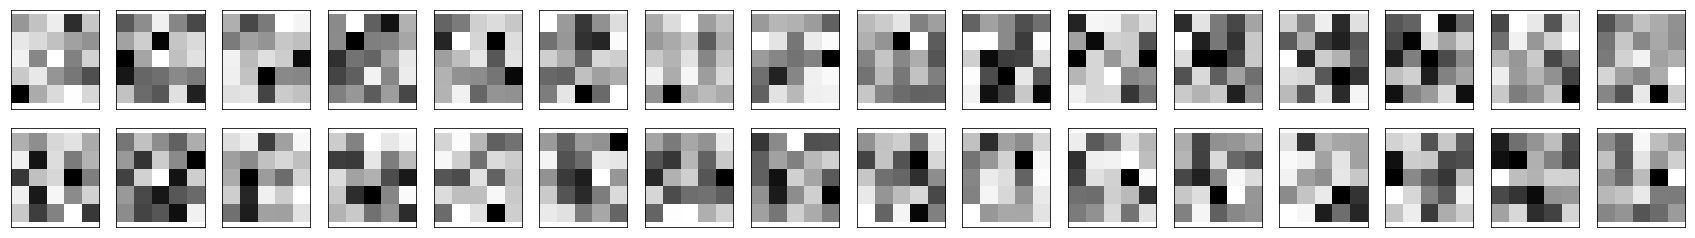

step 22000, training accuracy 0.7
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


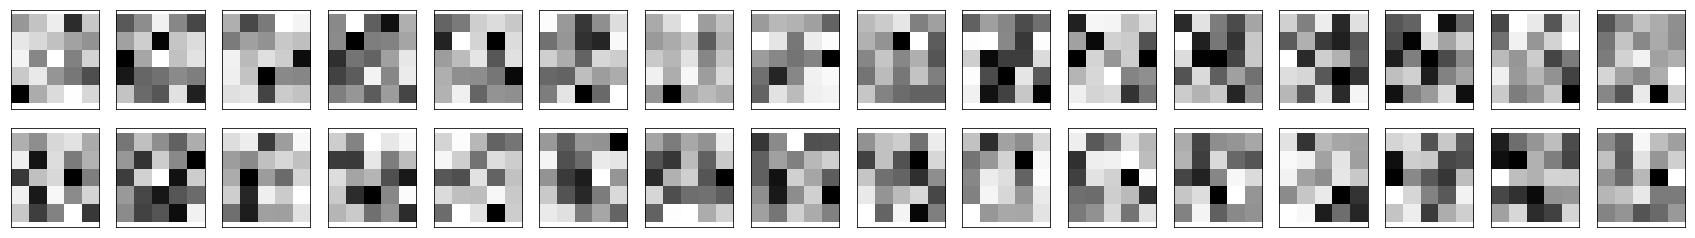

step 23000, training accuracy 0.66
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


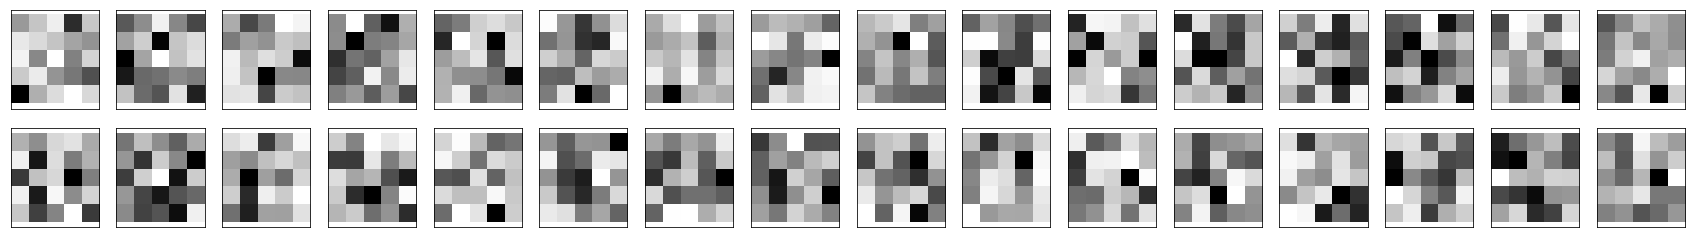

step 24000, training accuracy 0.71
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


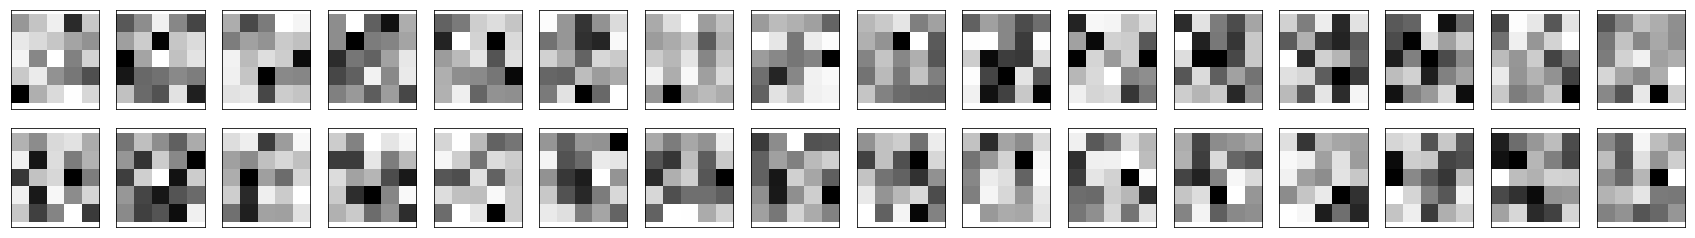

step 25000, training accuracy 0.69
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


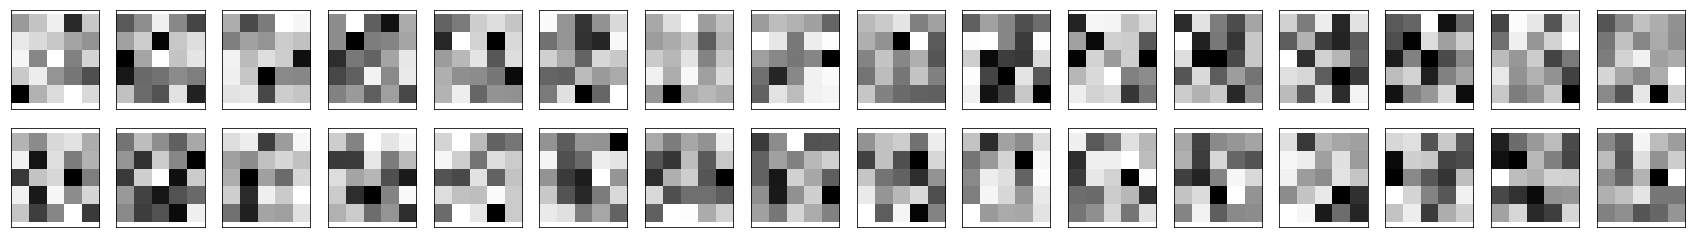

step 26000, training accuracy 0.69
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


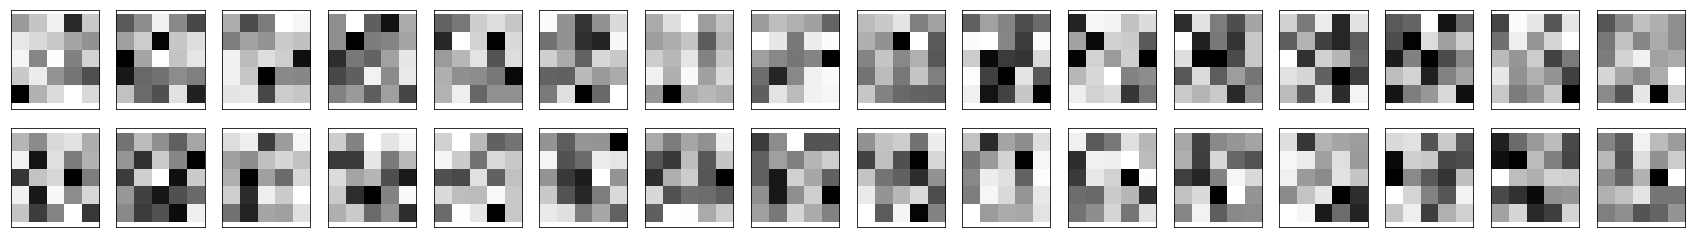

step 27000, training accuracy 0.7
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


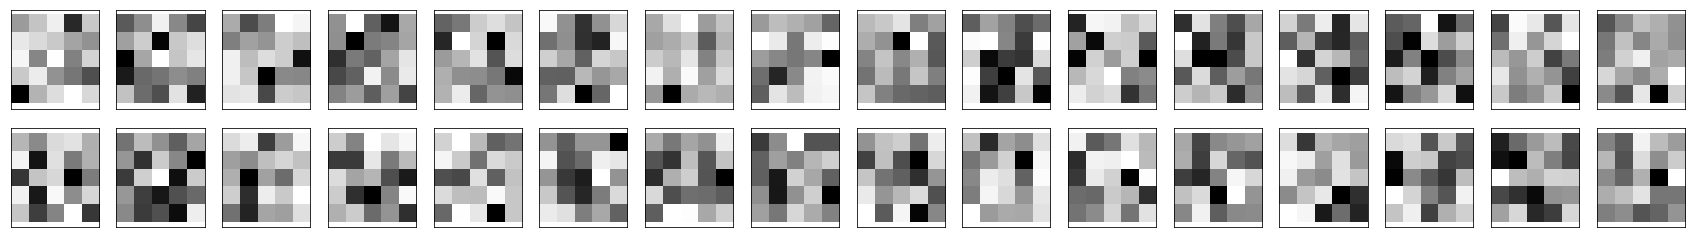

step 28000, training accuracy 0.68
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


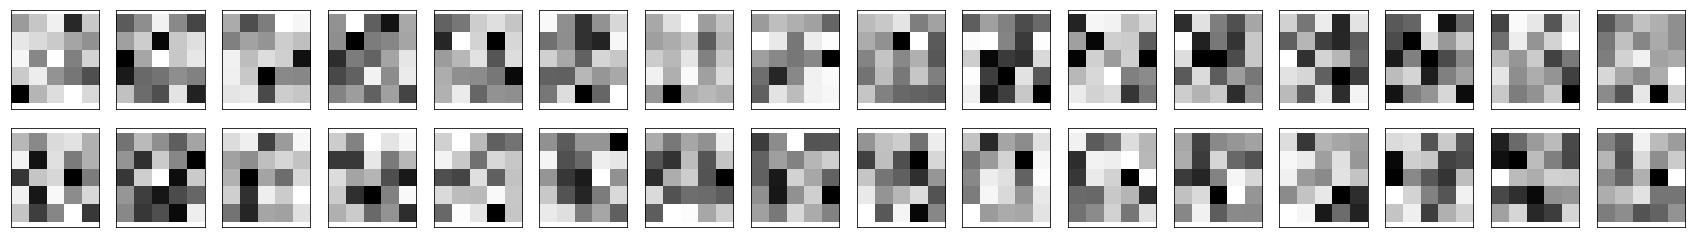

step 29000, training accuracy 0.67
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


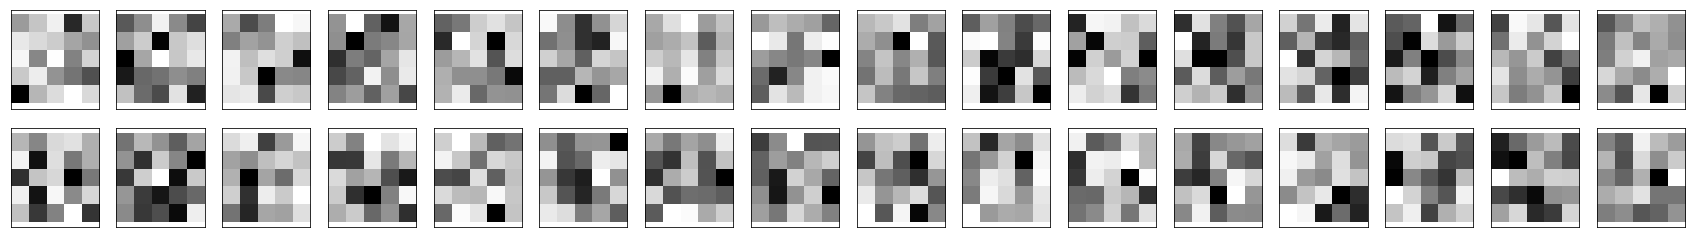

step 30000, training accuracy 0.77
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


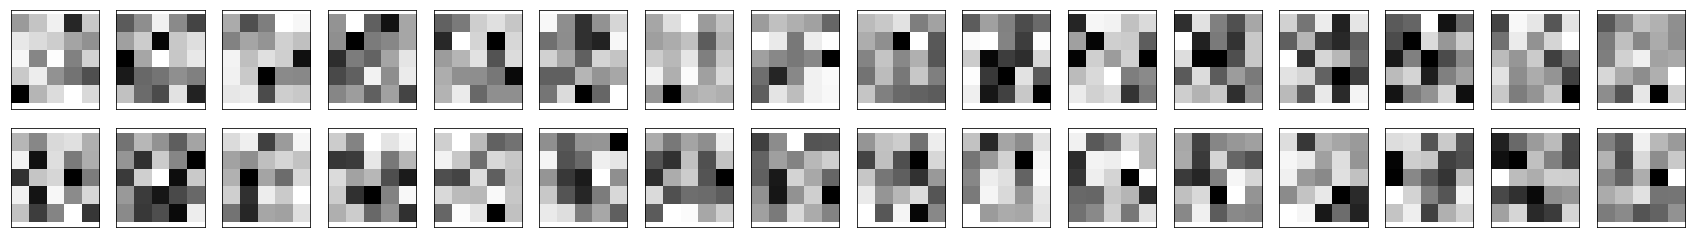

step 31000, training accuracy 0.79
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


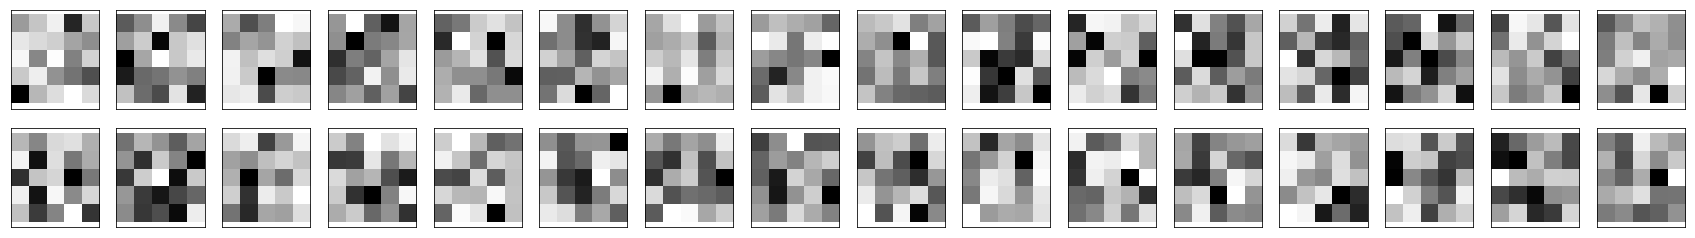

step 32000, training accuracy 0.69
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


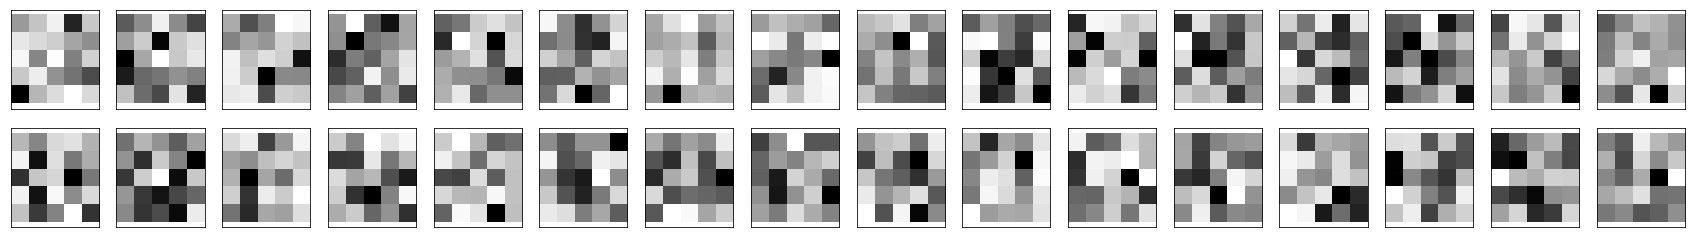

step 33000, training accuracy 0.74
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


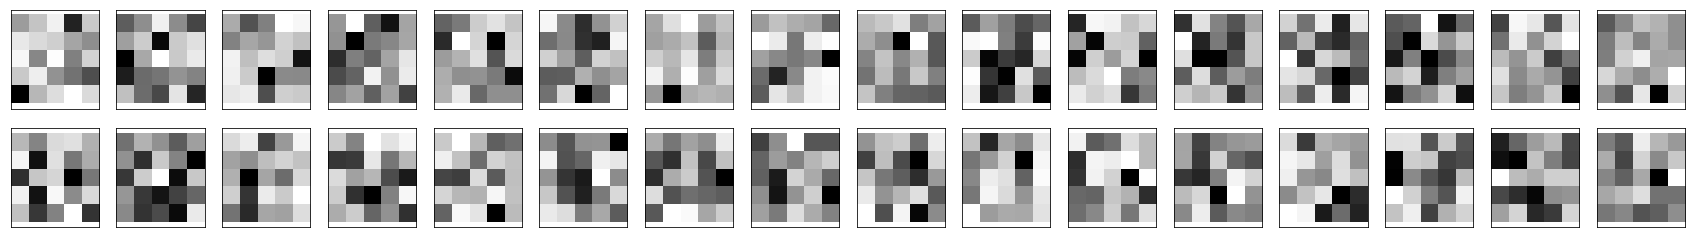

step 34000, training accuracy 0.75
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


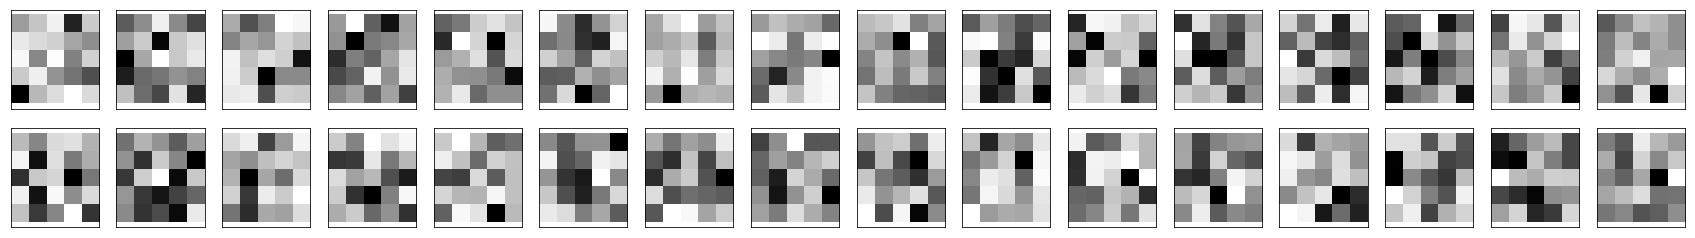

step 35000, training accuracy 0.68
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


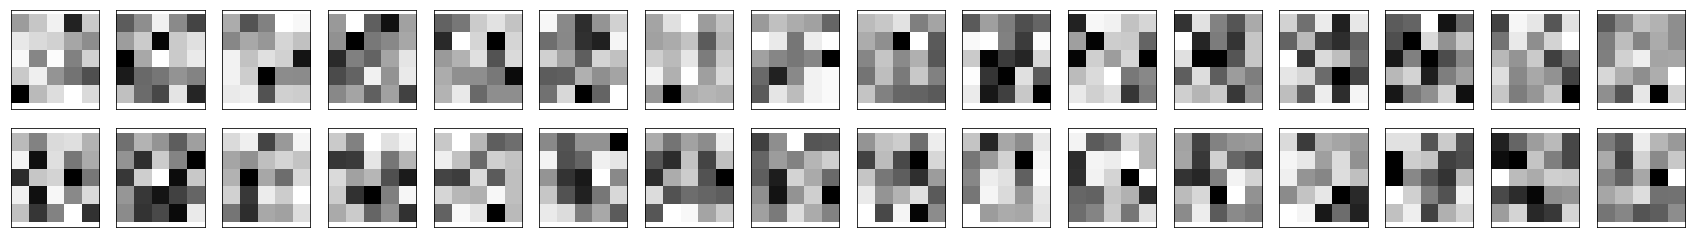

step 36000, training accuracy 0.7
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


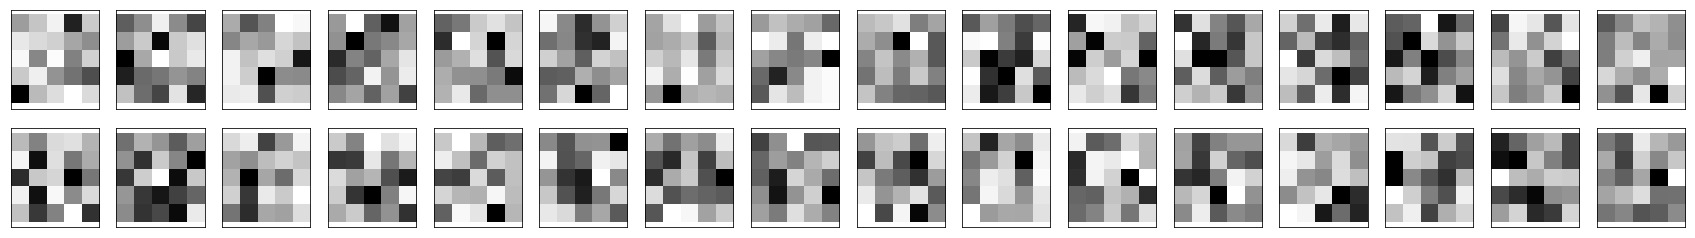

step 37000, training accuracy 0.74
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


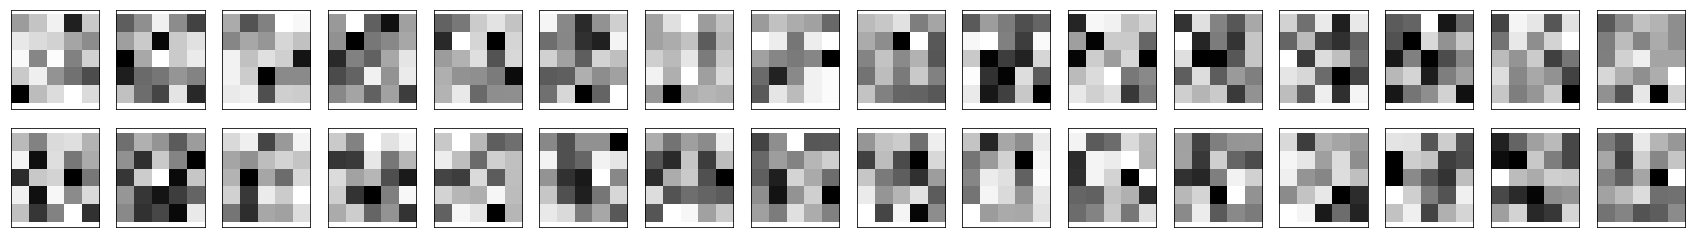

step 38000, training accuracy 0.68
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


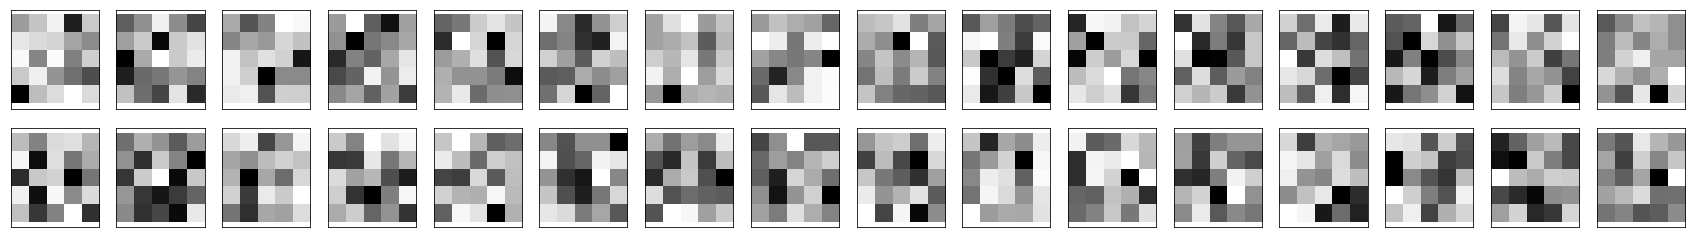

step 39000, training accuracy 0.68
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


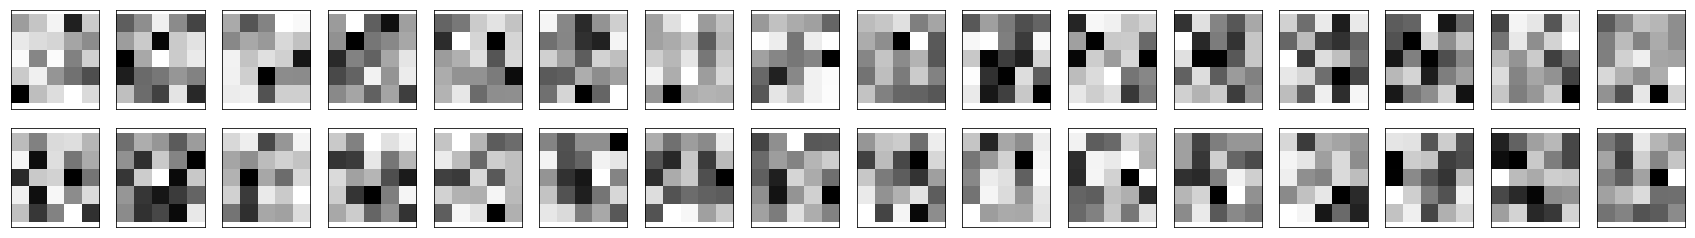

step 40000, training accuracy 0.69
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


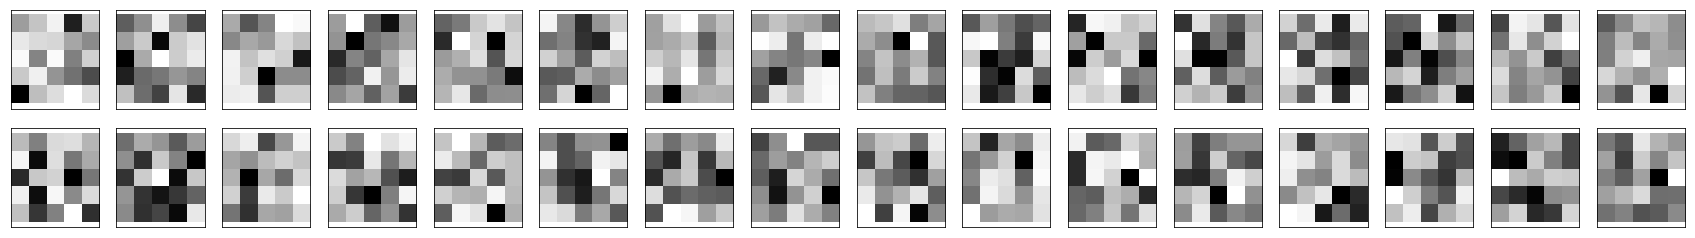

step 41000, training accuracy 0.76
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


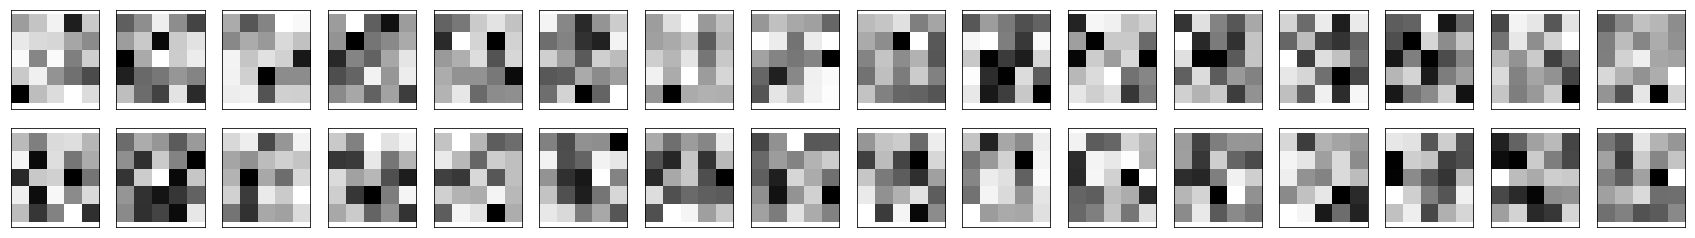

step 42000, training accuracy 0.77
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


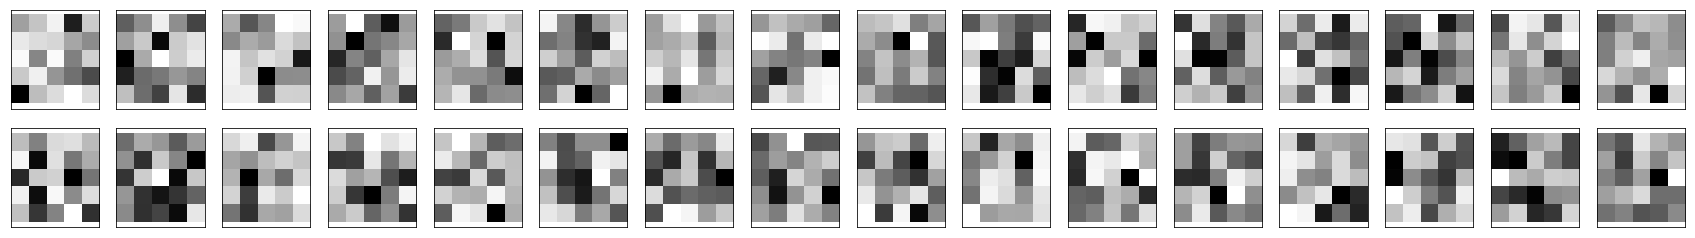

step 43000, training accuracy 0.73
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


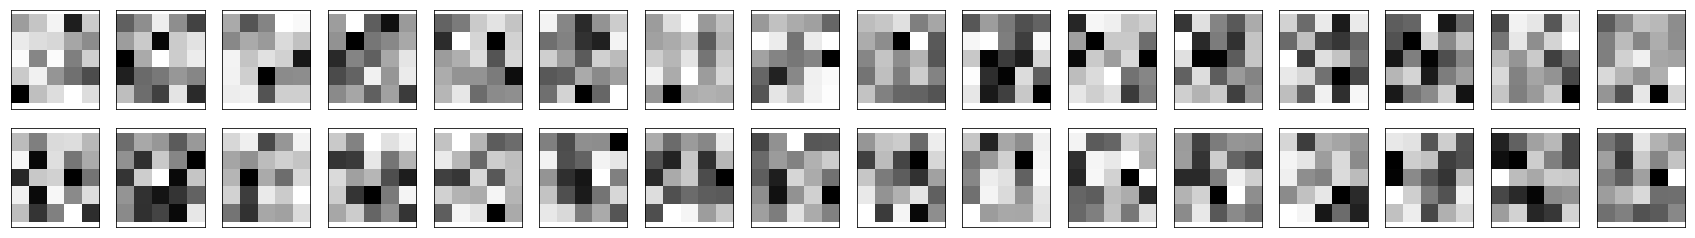

step 44000, training accuracy 0.73
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


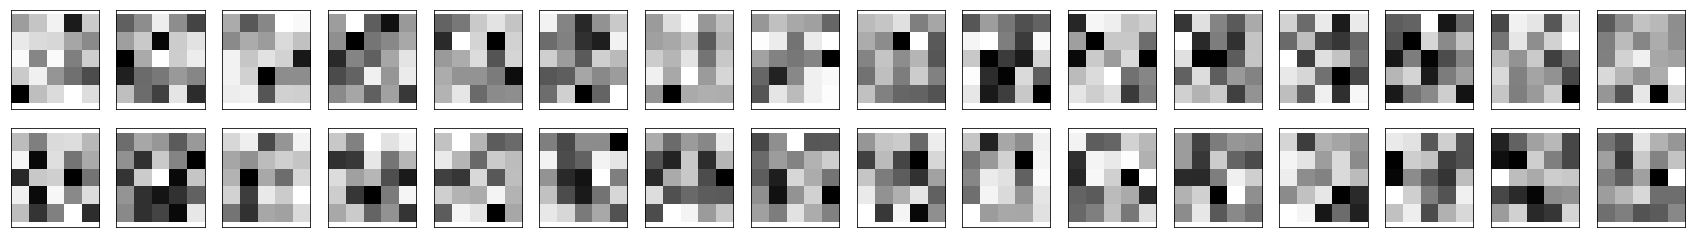

step 45000, training accuracy 0.75
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


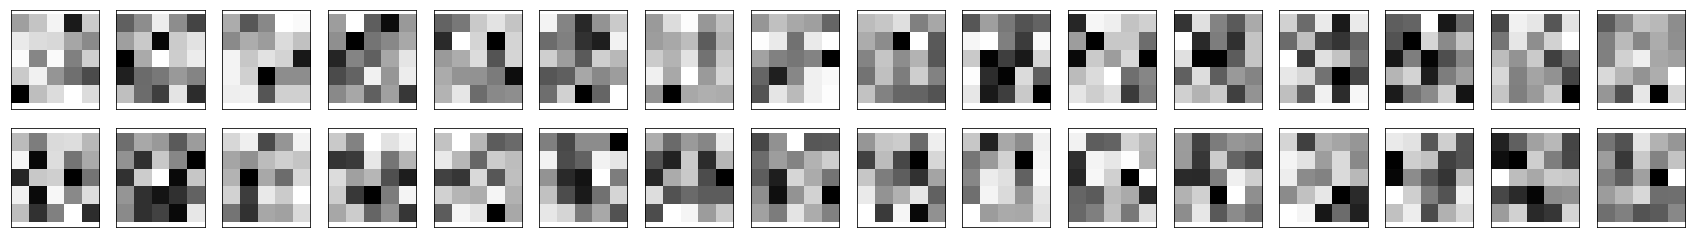

step 46000, training accuracy 0.7
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


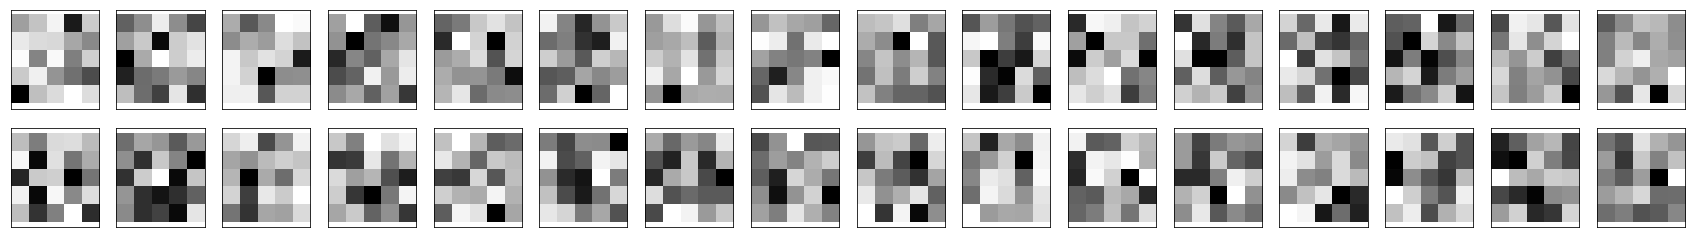

step 47000, training accuracy 0.8
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


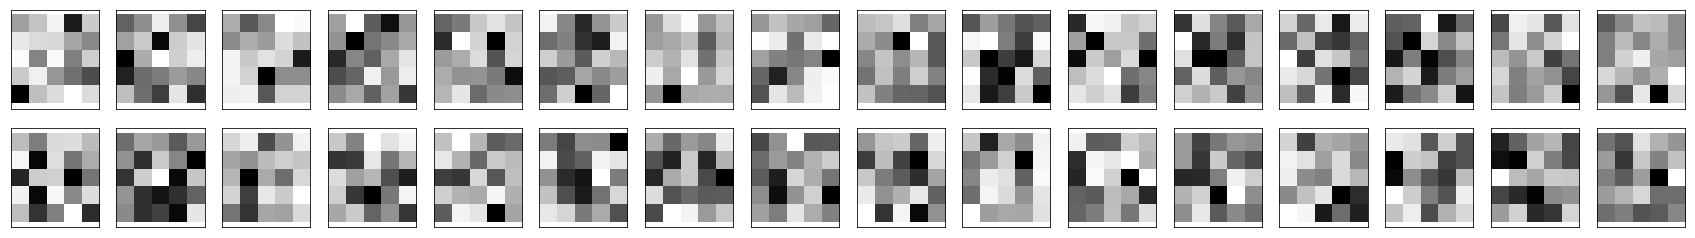

step 48000, training accuracy 0.73
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


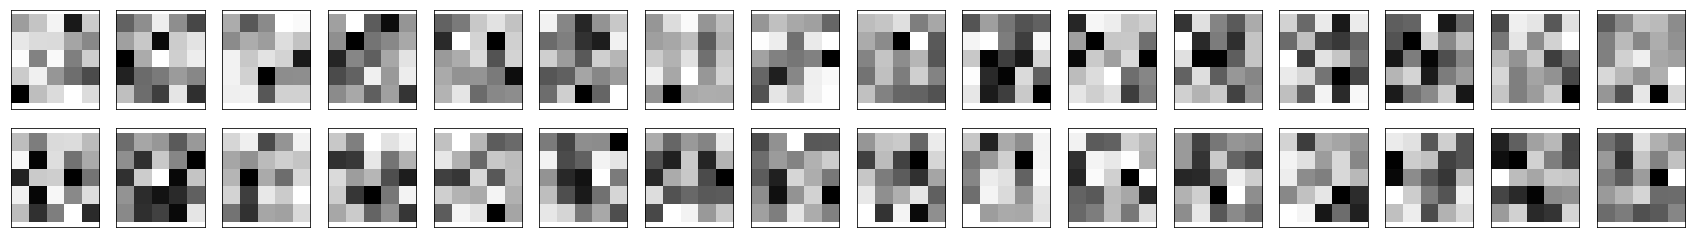

step 49000, training accuracy 0.77
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


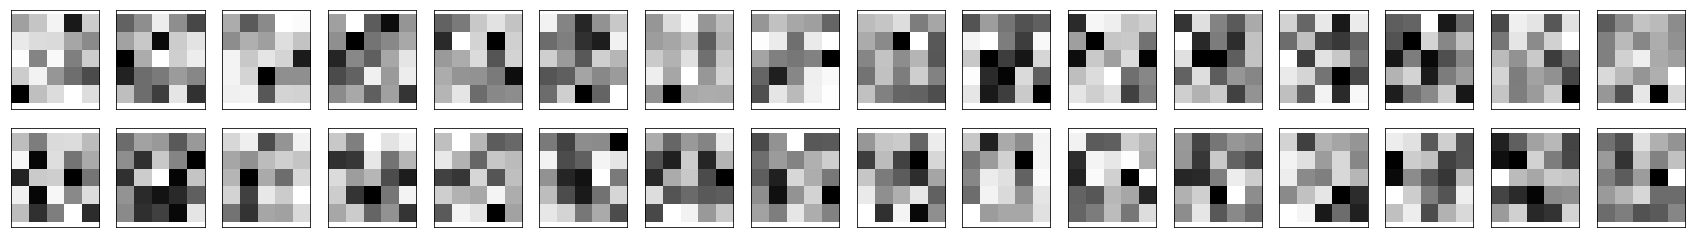

step 50000, training accuracy 0.82
(5, 5, 1, 32)
(32, 5, 5, 1)
cols = 16, rows = 2


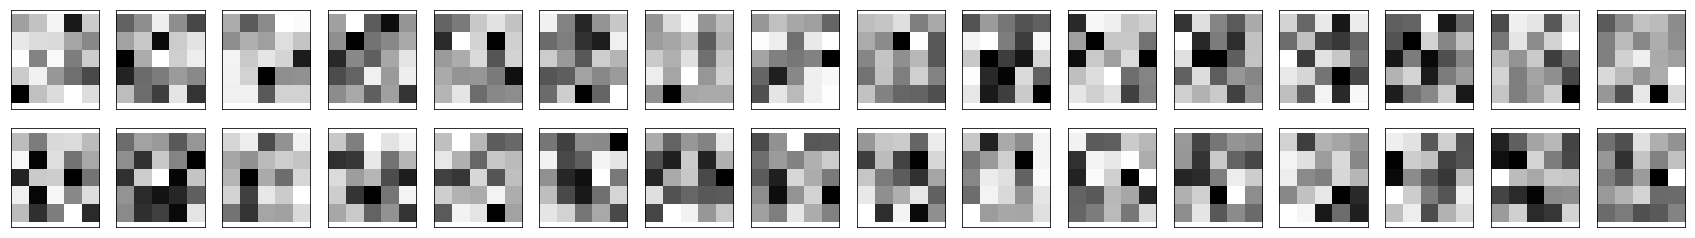

In [65]:
learning_rate = 1e-4

tf.reset_default_graph()
sess = tf.Session()

x = tf.placeholder(tf.float32, shape=[None, 1024], name="x")
y = tf.placeholder(tf.float32, shape=[None, 10], name="labels")
keep_prob = tf.placeholder(tf.float32)

x_image = tf.reshape(x, [-1, 32, 32, 1])

tf.summary.image('input', x_image, 3)

conv1 = conv_layer(x_image, 1, 32, name="conv1")
conv2 = conv_layer(conv1, 32, 64, name="conv2")

flattened = tf.reshape(conv2, [-1, 8 * 8 * 64])
dropped = dropout_layer(flattened, keep_prob)
logits = fc_layer(dropped, 8 * 8 * 64, 10, "fc")

with tf.name_scope("xent"):
    xent = tf.reduce_mean(
               tf.nn.softmax_cross_entropy_with_logits(
               logits=logits, labels=y), name="xent")
    
    tf.summary.scalar("xent", xent)

with tf.name_scope("train"):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(xent)

with tf.name_scope("accuracy"):
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar("accuracy", accuracy)    
    
summ = tf.summary.merge_all()
    
sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter('/tmp/tb/cifar10_cnn')
writer.add_graph(sess.graph)

dataset = Dataset(X_train, y_train)

for i in range(50001):
    batch = dataset.next_batch(100)
    
    if i % 1000 == 0:
        [training_accuracy, s] = sess.run([accuracy, summ], feed_dict={x: batch[0], 
                                                                       y: batch[1],
                                                                       keep_prob: 1.0})
    
        writer.add_summary(s, i)

        print('step %d, training accuracy %g' % (i, training_accuracy))
        
        # show
        with tf.variable_scope("vs", reuse=True):
            weights = tf.get_variable("conv1_W")
            bias = tf.get_variable("conv1_B")
            w = weights + bias
            print(w.shape)
            img_tensor = to_image_tensor(w)
            print(img_tensor.shape)
            data = img_tensor.eval(session=sess).squeeze()
            show_images(data)            
        
    sess.run(train_step, feed_dict={x: batch[0], 
                                    y: batch[1],
                                    keep_prob: 0.5})


sess.close()